## **AlexNet-like architecture**

During the first phase of the project, we also tried an AlexNet-like architecture, after properly resizing the images to fit the net ( originally implemented to fit on 227x227 images).

In this case, the training is performed by applying both simple geometric transformations, as well as the use of a custom made random CutOut filter, thoughtfully inserted in the model to force ‘independence’ among neurons in the CNN part of the net.

The *batch size* was chosen to be *relatively small* (32, 64) as it was thought to be a better fit for the task, as emerged while experimenting with this and other (successive) architectures. This model reached a satisfactory accuracy on the **validation set** of about **83%** but a rather disappointing maximum of 59% on the test set in the development phase.
Please note that, at this stage, the class imbalance was still being voluntarily ignored.


In [ ]:
# Connect to google drive files
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_1/

# Import libraries and dependecies

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
from collections import defaultdict

import logging

import random

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Setting seed
seed = 203
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)




Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1t7Zw2S8YfwDA0vUXDV4Dg7P1x8EvaxRE/homework_1
2.14.0


In [ ]:
#-------------------------------------------
#      IMAGE PROCESSING AND IMPORT
#-------------------------------------------

def setup(filename, unzip= False):

  # Unzip the '.zip' file if the 'unzip' flag is True
  if unzip:
      !unzip "$filename".zip

  dataset = np.load(filename+'.npz', allow_pickle=True)
  data = dataset['data']
  labels = dataset['labels']

  # Normalize the image pixel values to a float range
  for img in range(data.shape[0]):
    data[img] = (data[img] / 255).astype(np.float32)

  print("Original size of data:", data.shape)
  print("Original size of labels:", labels.shape)

  return data, labels


data,labels = setup('public_data')



# Convert labels to one-hot encoding format
print("The first 10 labels are:")
print(labels[:10])
labels = pd.get_dummies(labels).to_numpy().astype(np.float32)
print("Converted into:")
print(labels[:10])

Original size of data: (5200, 96, 96, 3)
Original size of labels: (5200,)
The first 10 labels are:
['healthy' 'healthy' 'healthy' 'unhealthy' 'unhealthy' 'healthy'
 'unhealthy' 'healthy' 'healthy' 'healthy']
Converted into:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


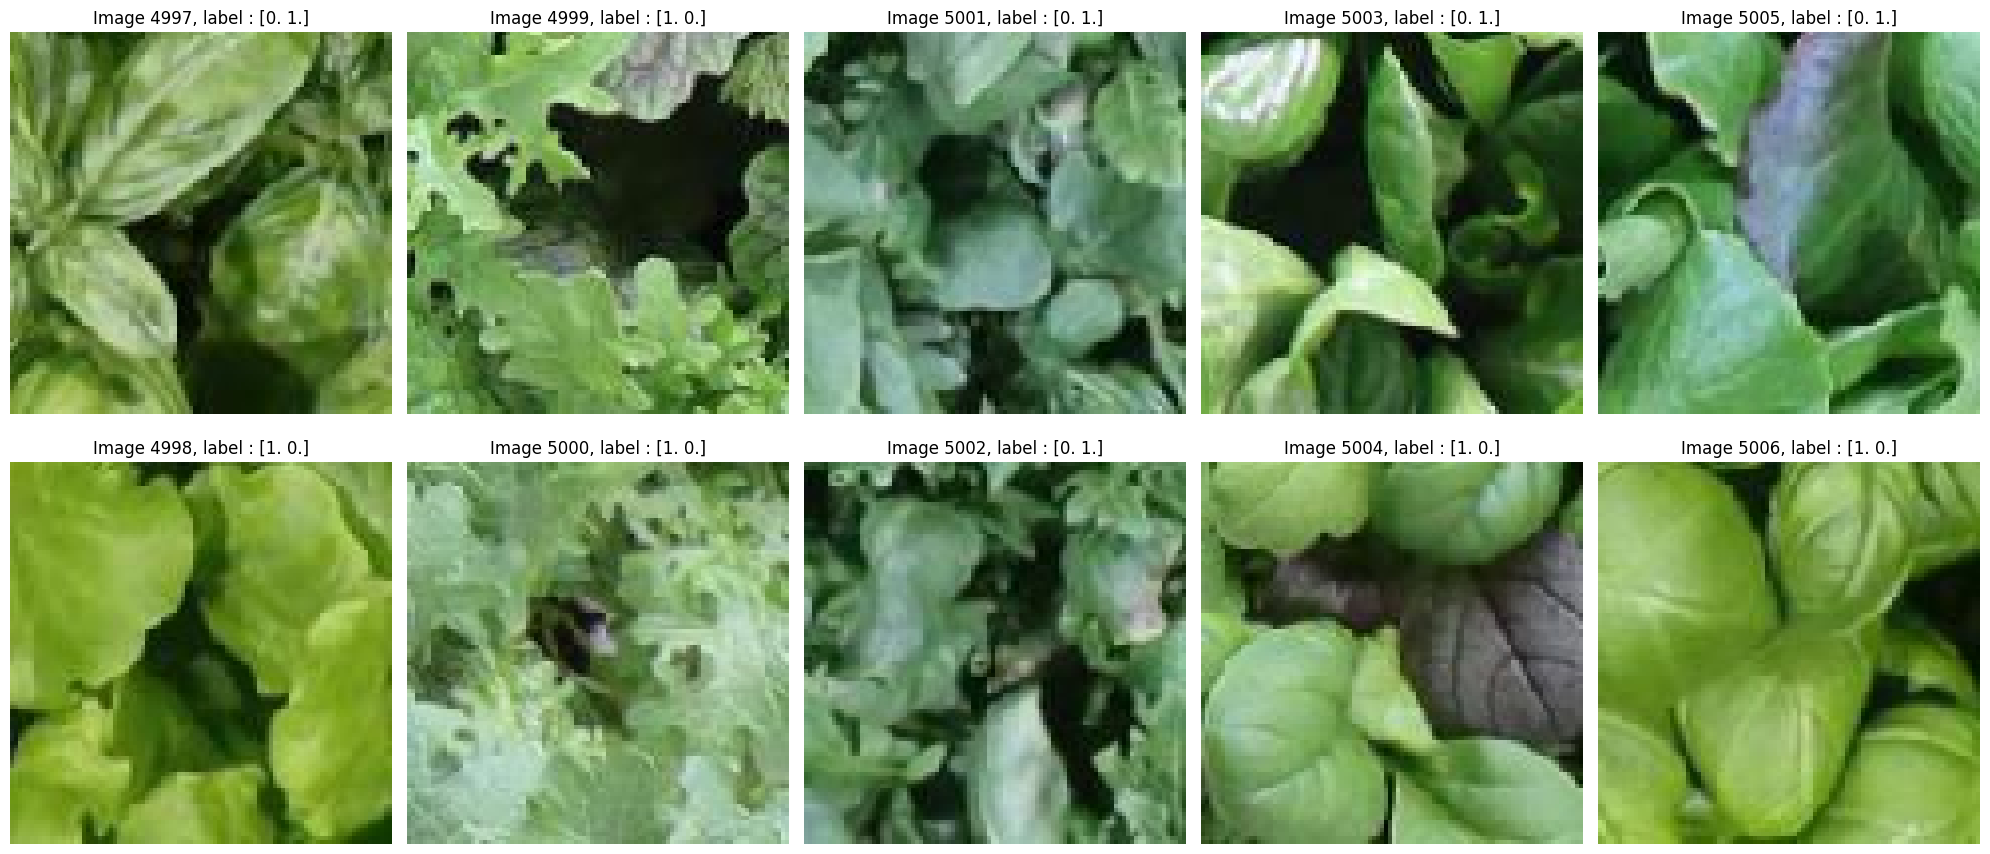

In [ ]:
#-----------------------------
#       DATA INSPECTION
#-----------------------------



# Plot some pictures form the dataset
# Number of images to display
num_img = 10
random_offset = np.random.randint(5089)

# Create subplots to display data
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(data[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {labels[i+random_offset]}')
plt.tight_layout()
plt.show()

In [ ]:

#----------------------------------------------------------------------------------------
#
#                                - DATA CLEAN-UP UTILS -
#
#----------------------------------------------------------------------------------------

# Remove multiple instances of the same images (Shrek and trololo "outliers")

# Hash of an image:
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# Find duplicates in the data
def clean_data(data, labels, delete = True):

    print("Cleaning data...")

    image_hashes = {} # Dictionary for unique images
    duplicates = [] # List of duplicated images

    new_data = []  # Initialize a list for unique images
    new_labels = []  # Initialize a list for unique labels

    for i, image in enumerate(data):
        h = dhash(image)
        if h in image_hashes:
            duplicates.append((i, image_hashes[h], image, np.argmax(labels[i])))
        else:
            image_hashes[h] = i
            #print("Image:",i,"- Label:", labels[i])
            new_data.append(image)
            new_labels.append(labels[i])


    # Count duplicates with different labels and different image hashes
    duplicate_counts = defaultdict(lambda: defaultdict(int))

    for i, (_,hash_value,_,label) in enumerate(duplicates):
      duplicate_counts[hash_value][label] += 1

    for hash_value, label_counts in duplicate_counts.items():
      for label, count in label_counts.items():
        # Print the most relevant counts for the duplicates
        if count > 5:
          print(f"Image Hash: {hash_value}")
          print(f"  Label: {label}, Duplicates count: {count}")
          # Delete the original copy of data
          if delete == True:
            # Get the hash of the orginal (first)image
            h_0 = dhash(data[hash_value])
            # Loop over the new_data list and search for the original image
            for i, image in enumerate(new_data):
              h = dhash(image)
              # Once found, remove it...
              if h == h_0:
                new_data.pop(i)
                new_labels.pop(i)

        elif delete == False:
          for i in range(count):
            new_data.append(data[hash_value])
            new_labels.append(labels[hash_value])


    new_data = np.array(new_data)
    new_labels = np.array(new_labels)


    print("The total number of duplicates is :", len(duplicates))


    print('Data cleaned!')

    return new_data, new_labels, duplicates, image_hashes

# A custom defined function to check on the correctness of the data
def check_correctness(data,label, cleaned_data, cleaned_label, image_hashes):
  count = 0
  #For each element in the cleaned data array, compute the hash function
  for i, image1 in enumerate(cleaned_data):
    h1 = dhash(image1)
    # Fetch the index of the corresponding image in the original dataset
    j = image_hashes[h1]
    h2 = dhash(data[j])
    if h1 == h2:
      if not (np.array_equal(cleaned_label[i],label[j])):
        count+= 1
    else:
      print("Somthing went wrong in the cleaning of the data...")
  print("Total number of inconsistent data is:", count)
  return

#----------------------------------------------------------------------------------------
# Clean the data
data_new,labels_new,duplicates,valid_images = clean_data(data,labels, True)
# Check for correctness of data cleaning
check_correctness(data, labels, data_new, labels_new, valid_images)


print(data_new.shape)
print(labels_new.shape)
# Split train_val into train and validation sets in 0.9-0.1 proportion



Cleaning data...
Image Hash: 58
  Label: 1, Duplicates count: 97
Image Hash: 338
  Label: 0, Duplicates count: 97
The total number of duplicates is : 348
Data cleaned!
Total number of inconsistent data is: 0
(4850, 96, 96, 3)
(4850, 2)



Here are the cleaned images...



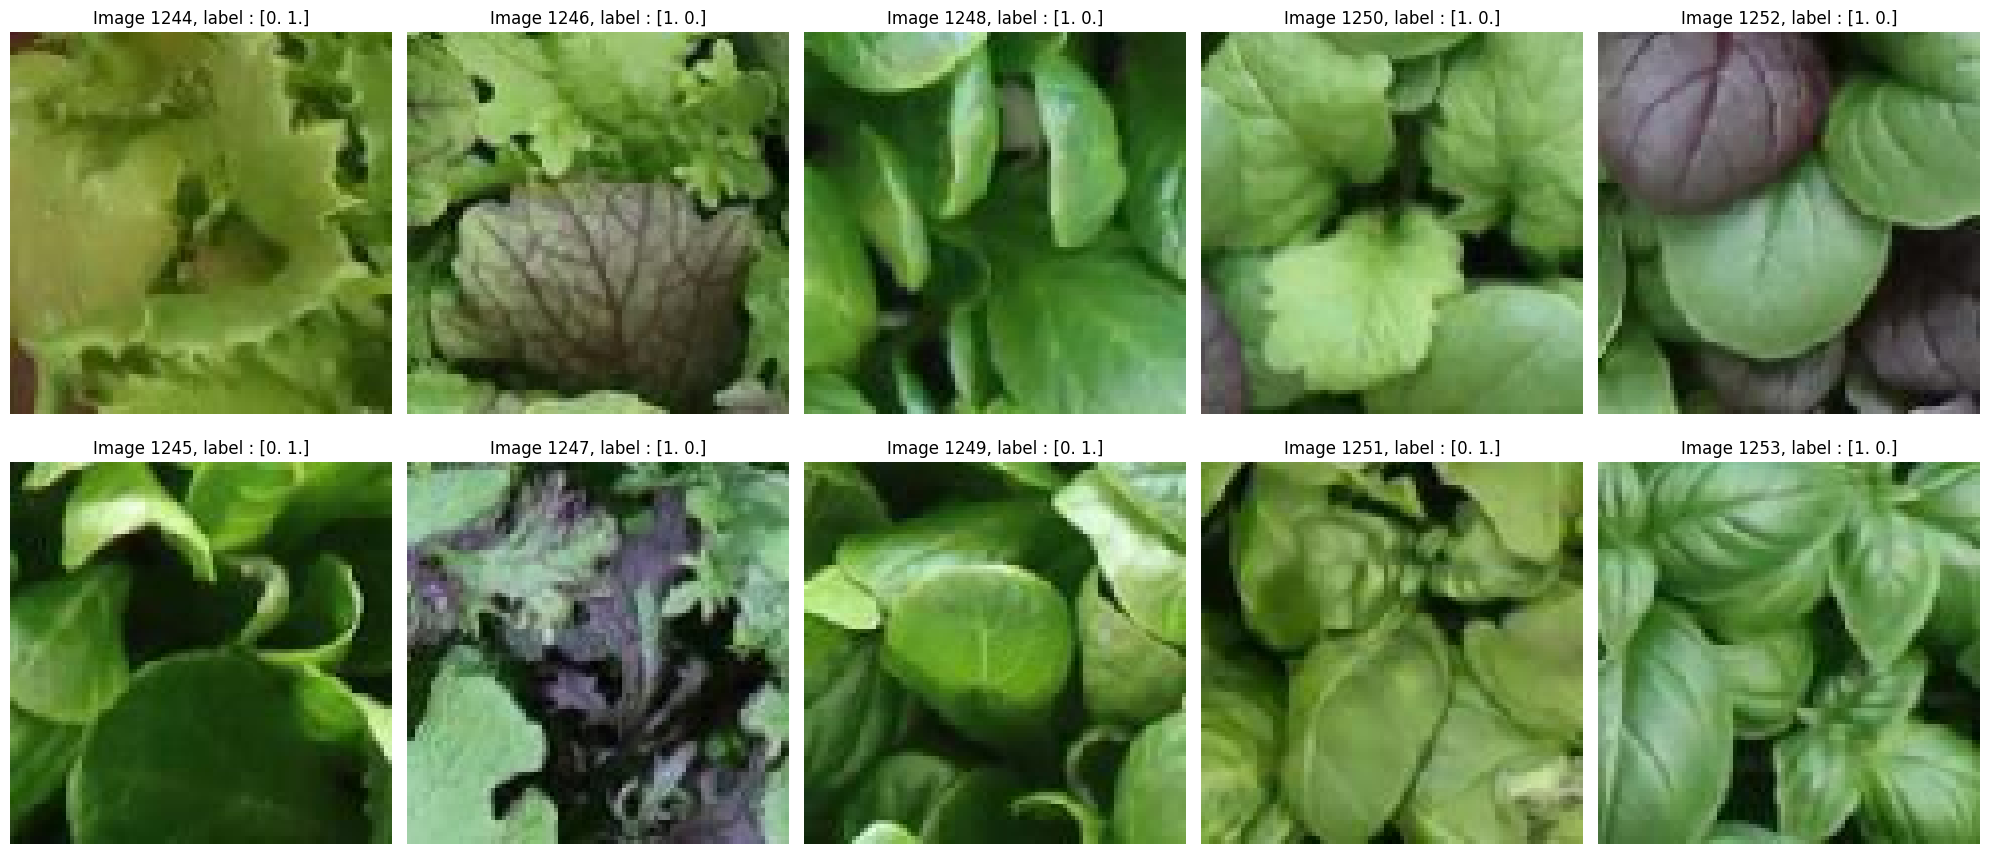

In [ ]:
num_img  = 10
random_offset = random_offset = np.random.randint(5089 - len(duplicates))

print('\nHere are the cleaned images...\n')
# Create subplots to display data (cleaned)
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(data_new[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {labels_new[i + random_offset]}')
plt.tight_layout()
plt.show()



In [ ]:
def build_model_Alex():


  # Initializing the CNN
  model = tfk.Sequential([

    # Convolution Step 1
    tfkl.Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(227, 227, 3), activation = 'relu'),


    # Max Pooling Step 1
    tfkl.MaxPooling2D(pool_size = (3,3), strides = (2, 2), padding = 'valid'),
    tfkl.BatchNormalization(),

    # Convolution Step 2
    tfkl.Convolution2D(256, 5, strides = (1, 1), padding='valid', activation = 'relu'),

    # Max Pooling Step 2
    tfkl.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding='valid'),
    tfkl.BatchNormalization(),

    # Convolution Step 3
    tfkl.Convolution2D(256, 3, strides = (1, 1), padding='valid', activation = 'relu'),
    tfkl.BatchNormalization(),

    # Convolution Step 4
    tfkl.Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'),
    tfkl.BatchNormalization(),

    # Convolution Step 5
    tfkl.Convolution2D(384, 3, strides=(1,1), padding='valid', activation = 'relu'),
    tfkl.BatchNormalization(),

    # Max Pooling Step 3
    tfkl.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid'),
    tfkl.BatchNormalization(),

    # Flattening Step
    tfkl.Flatten(),
    # Full Connection Step
    tfkl.Dense(units = 9216, kernel_initializer = 'glorot_uniform',activation = 'relu'),
    tfkl.Dropout(0.4),
    tfkl.BatchNormalization(),
    tfkl.Dense(units = 2024, kernel_initializer = 'glorot_uniform',activation = 'relu'),
    tfkl.Dropout(0.4),
    tfkl.BatchNormalization(),
    tfkl.Dense(units = 128, kernel_initializer = 'glorot_uniform',activation = 'relu'),
    tfkl.Dropout(0.4),
    tfkl.BatchNormalization(),
    tfkl.Dense(units = 2, kernel_initializer = 'glorot_uniform',activation = 'softmax'),
    # Two neurons to work with mixup augmentation

  ], name = "modAlexNet")


  return model

Reference for the cutout custom defined funcion:
https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

In [ ]:
#----------------------------------------------------------------------------------------
#
#                                -  DATA AUGMENTATION -
#
#----------------------------------------------------------------------------------------

# Define the function to implement random cutout

# ---- CUTOUT PREPROCESSING FUNCTION ----

def eraser(input_img):

    p=0.5
    s_l=0.03
    s_h=0.1
    r_1=0.3
    r_2=1/0.3
    v_l=0
    v_h=0
    pixel_level=False
    if input_img.ndim == 3:
        img_h, img_w, img_c = input_img.shape
    elif input_img.ndim == 2:
        img_h, img_w = input_img.shape

    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        if input_img.ndim == 3:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        if input_img.ndim == 2:
            c = np.random.uniform(v_l, v_h, (h, w))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w] = c

    return input_img


#----------------------------------------------------------------------------------------


In [ ]:
# Initially, build the model and link it to the 'normally' preprocessed dataset
X_train, X_val, y_train, y_val = train_test_split(data_new, labels_new, test_size=0.1, stratify=np.argmax(labels_new,axis=1)) # random state as stratify is not possible


X_train0 = X_train
X_val0 = X_val
y_train0 = y_train
y_val0 = y_val

X_train = tf.image.resize(X_train,(227, 227))
X_val = tf.image.resize(X_val,(227, 227))


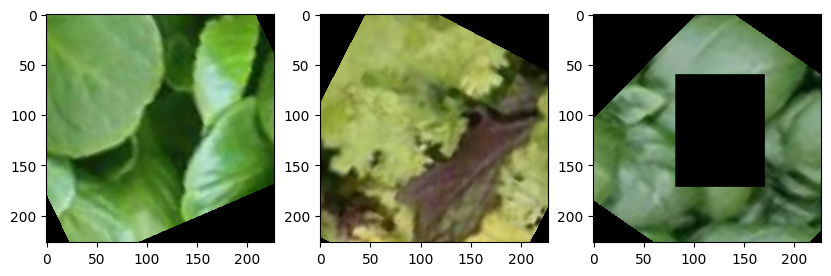

Epoch 1/200
69/69 [==============================] - 74s 808ms/step - loss: 0.8531 - accuracy: 0.5608 - val_loss: 10.5724 - val_accuracy: 0.3897 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 72s 1s/step - loss: 0.7409 - accuracy: 0.5890 - val_loss: 0.8134 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 56s 808ms/step - loss: 0.6977 - accuracy: 0.6286 - val_loss: 0.6764 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 54s 776ms/step - loss: 0.6593 - accuracy: 0.6504 - val_loss: 0.7744 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 5/200
69/69 [==============================] - 53s 775ms/step - loss: 0.6303 - accuracy: 0.6767 - val_loss: 0.7244 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 6/200
69/69 [==============================] - 53s 772ms/step - loss: 0.6197 - accuracy: 0.6777 - val_loss: 0.7379 - val_accuracy: 0.6351 - lr: 0.0010
Epoch 7/200
69/69 [==============================] - 54s 784

In [ ]:
train_gen = ImageDataGenerator(

    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=eraser,
    rotation_range=180,
    zoom_range=0.2,
    height_shift_range=0.15,
    width_shift_range=0.15,
    fill_mode='constant',

    )

val_gen = ImageDataGenerator()

train_generator = train_gen.flow(X_train,y_train,batch_size=64)
val_generator = val_gen.flow(X_val, y_val, batch_size = 64)

#Creates our batch of 4 images
pic = train_gen.flow(X_train, batch_size =4)
plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('float32')
  plt.imshow(image_)
plt.show()



#------------------------------------
#           BUILD THE NETWORK
#------------------------------------
model = tfk.Sequential()
model.add(tfkl.Input(shape= (227, 227, 3)))
base = build_model_Alex()
model.add(base)

optimizer = tfk.optimizers.Adam(learning_rate = 1e-3)
loss='categorical_crossentropy',
metrics=['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

model.summary()

tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)
#------------------------------------

# Train the model using the DataImageGenerator object
history = model.fit(
    train_generator,
    batch_size = 64,
    epochs = 200,
    validation_data = val_generator, # NOTE THAT THE IMAGES ARE IN THE RANGE [0,1]
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-6, mode='max')
    ]
).history


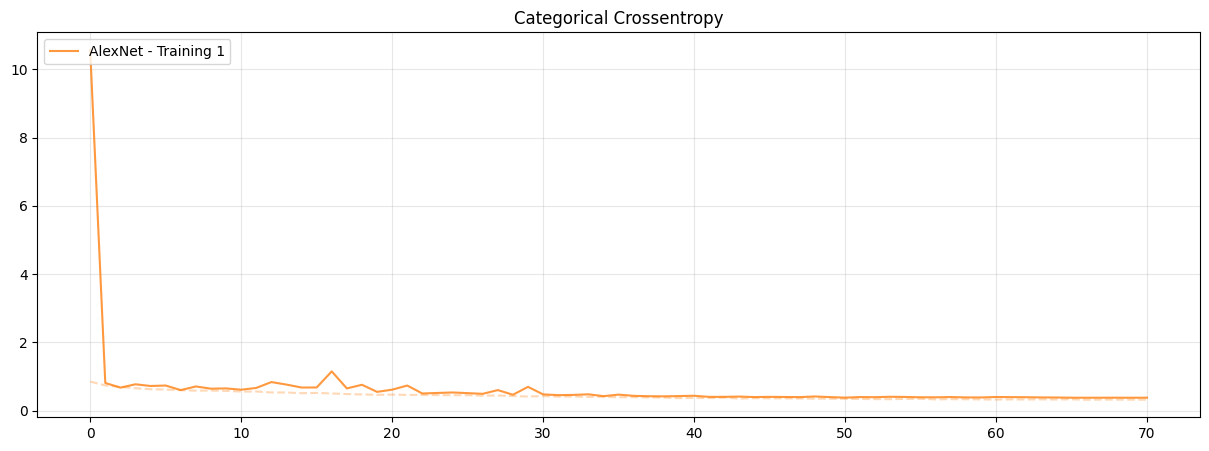

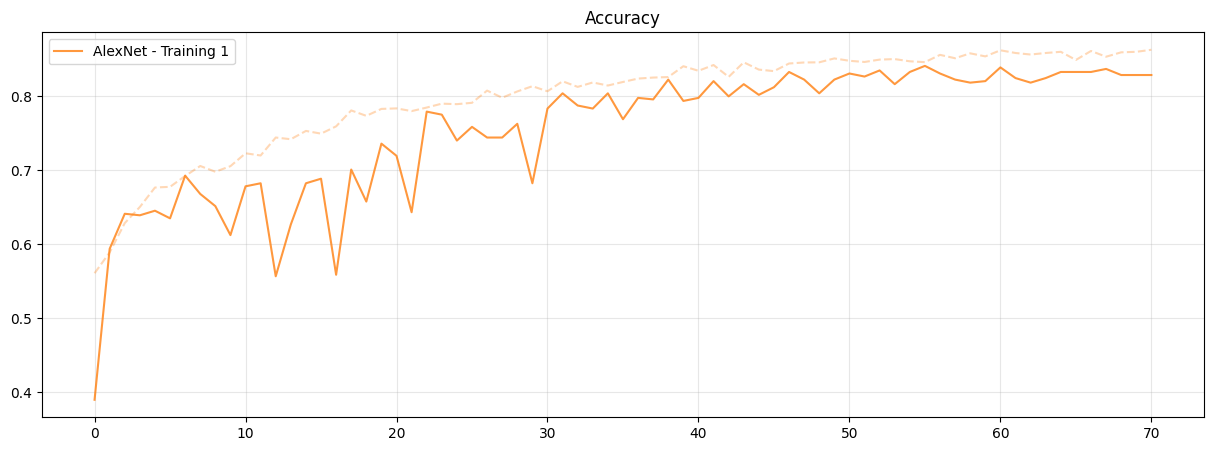

In [ ]:
# Plot the data of the model after the fist step of fine tuning
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='AlexNet - Training 1', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='AlexNet - Training 1', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Save the model
model.save("AlexNet/Alex01")
del model

16/16 [==============================] - 1s 27ms/step
[0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0]
tf.Tensor(
[0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1
 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0
 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0

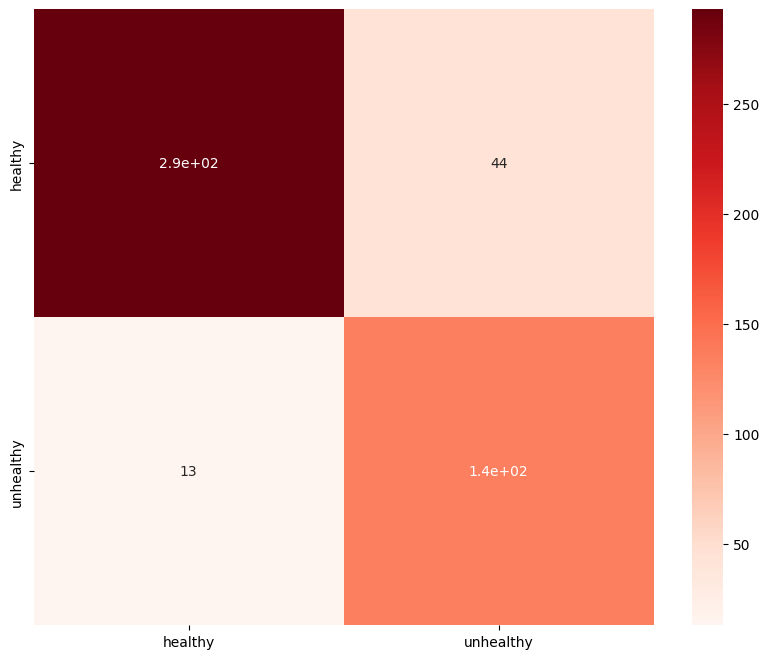

In [ ]:
model = tfk.models.load_model("AlexNet/Alex01")

predictions = model.predict(X_val)  # IMAGES NORMALIZED IN THE RANGE 0,1
test_accuracy = model.evaluate(X_val ,y_val,verbose=0)[-1]


print(np.argmax(y_val[:20], axis = 1))
print (tf.argmax(predictions, axis=-1))
print(test_accuracy)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Reds', annot=True)

del model